In [2]:
import torch
import matplotlib.pyplot as plt
from models import Generator
import torch.nn.functional as F
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
cifar_mapping = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [80]:
def intra_class_latent_space_interpolation(generator, latent_steps=10, latent_size=100, num_classes=10, class_label=1):
    if not os.path.exists("final_images"):
        os.makedirs("final_images")

    generator.eval()

    gen_label = torch.tensor([class_label] * latent_steps).to(device)
    one_hot_labels = F.one_hot(gen_label, num_classes).float().to(device)

    # Generate random latent vectors
    latent_start = torch.randn(1, latent_size).to(device)
    latent_end = torch.randn(1, latent_size).to(device)

    # Interpolate linearly between the two latent vectors
    interpolated_latents = torch.linspace(0, 1, latent_steps).view(-1, 1).to(device) * latent_end + (1 - torch.linspace(0, 1, latent_steps)).view(-1, 1).to(device) * latent_start

    # Concatenate interpolated latent vectors with one-hot labels
    interpolated_latents = torch.cat((interpolated_latents, one_hot_labels), dim=1)

    # Generate images from interpolated latent vectors
    generated_images = []
    for latent_vector in interpolated_latents:
        # Generate image from interpolated latent vector
        with torch.no_grad():
            latent_vector = latent_vector.view(1, -1)
            fake_images = generator(latent_vector)
            fake_images = fake_images / 2 + .5
        generated_images.append(fake_images)

    # Visualize the generated images
    if latent_steps > 7:
        num_rows = 2
        num_cols = latent_steps // 2
    else:
        num_rows = 1
        num_cols = latent_steps

    # Visualize the generated images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i, image in enumerate(generated_images):
        row_idx = i // num_cols
        col_idx = i % num_cols
        if num_rows > 1:
            ax = axes[row_idx, col_idx]
        else:
            ax = axes[col_idx]
        ax.imshow(image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"final_images/ls_interpolation_{cifar_mapping[class_label]}.png")
    plt.show()
    
    
def extra_class_latent_space_interpolation(generator, latent_size=100, num_classes=10):
    if not os.path.exists("final_images"):
        os.makedirs("final_images")

    generator.eval()

    # Generate random noise vector
    z = torch.randn(1, latent_size).to(device)
    
    latent_labels = torch.eye(num_classes).to(device)
    latent_vectors = torch.cat((z.repeat(num_classes, 1), latent_labels), dim=1)

    # Generate images from interpolated latent vectors
    generated_images = []
    for latent_vector in latent_vectors:
        # Generate image from interpolated latent vector
        with torch.no_grad():
            latent_vector = latent_vector.view(1, -1)
            fake_images = generator(latent_vector)
            fake_images = fake_images / 2 + .5
        generated_images.append(fake_images)
        
    num_rows = 1
    num_cols = num_classes

    # Visualize the generated images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i, image in enumerate(generated_images):
        row_idx = i // num_cols
        col_idx = i % num_cols
        if num_rows > 1:
            ax = axes[row_idx, col_idx]
        else:
            ax = axes[col_idx]
        ax.imshow(image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
        ax.axis('off')
        ax.set_title(cifar_mapping[i])
    plt.tight_layout()
    plt.savefig("final_images/label_interpolation_4.png")
    plt.show()


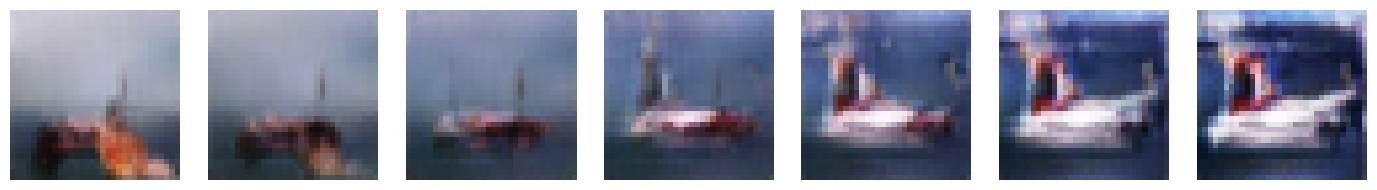

In [155]:
generator = Generator().to(device)
generator.load_state_dict(torch.load("final_models/final_generator.pth"))

intra_class_latent_space_interpolation(generator, latent_steps=7, class_label=8)

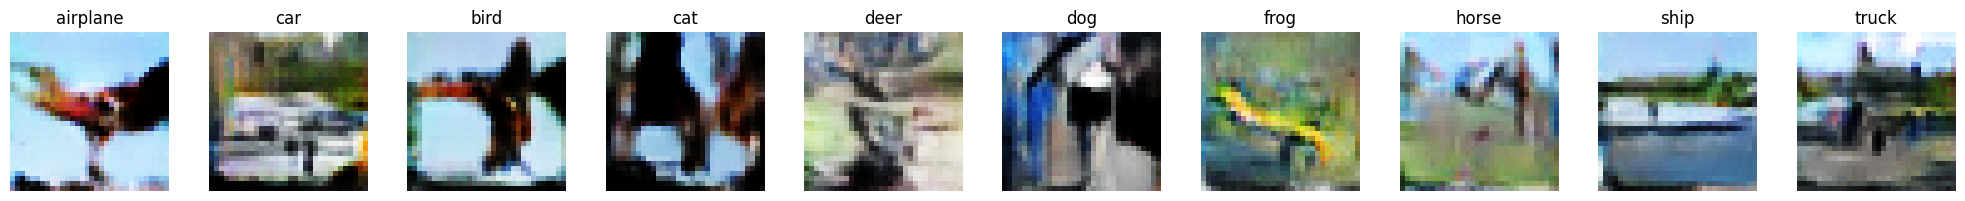

In [103]:
generator = Generator().to(device)
generator.load_state_dict(torch.load("final_models/final_generator.pth"))

extra_class_latent_space_interpolation(generator)